In [1]:
# Imports
import os
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

2025-08-14 04:02:15.818089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755144135.977522      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755144136.026576      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Giving Path to Data Directories
base_dir = '/kaggle/input/silicosis-trtest/gendata'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Image Parameters
img_size = (224, 224)
batch_size = 32

In [4]:
import cv2
import numpy as np

def clahe_preprocess(img):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE only to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    # Merge channels back
    lab = cv2.merge((l, a, b))
    # Convert LAB → RGB
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # Convert to float32 (Keras requirement) and normalize [0,1]
    img_clahe = img_clahe.astype(np.float32) / 255.0

    return img_clahe


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    height_shift_range=0.05,
    width_shift_range=0.02,
    rotation_range=0.3,
    shear_range=0.01,
    fill_mode='nearest',
    zoom_range=0.05,
)

test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 633 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [6]:
import os
import numpy as np

def load_images_and_labels(directory):
    classes = ['0', '1']
    filepaths, labels = [], []
    for label, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return np.array(filepaths), np.array(labels)

all_images, all_labels = load_images_and_labels(train_dir)
print(f" Loaded {len(all_images)} training images")


 Loaded 633 training images


In [7]:
# Load the VGG19 architecture
pre_trained_model = VGG19(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
#  Print layer names to identify the one before the output
pre_trained_model.trainable = False

I0000 00:00:1755144255.430806      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
def build_model():
    feature_output = pre_trained_model.output

    x = GlobalAveragePooling2D()(feature_output)
    x = BatchNormalization()(x)  
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)   
    x = Dropout(0.3)(x)
    x = Dense(64, activation='softplus')(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [9]:

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,200,513 (77.06 MB)

 Trainable params: 174,337 (681.00 KB)

 Non-trainable params: 20,026,176 (76.39 MB)

In [10]:
# Define paths
train_dir = '/kaggle/input/silicosis-trtest/gendata/train'
test_dir = '/kaggle/input/silicosis-trtest/gendata/test'
img_size = (224, 224) 
batch_size = 32

# Define label map
label_map = {0: '0', 1: '1'}

# Load file paths and labels
def get_image_paths_and_labels(directory):
    classes = sorted(os.listdir(directory))
    image_paths, labels = [], []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for fname in os.listdir(class_dir):
            path = os.path.join(class_dir, fname)
            if os.path.isfile(path):
                image_paths.append(path)
                labels.append(idx)
    return np.array(image_paths), np.array(labels)

# Load train and test sets
all_images, all_labels = get_image_paths_and_labels(train_dir)
test_images, test_labels = get_image_paths_and_labels(test_dir)


In [11]:
val_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

# Nested CV Setup
outer_folds = 5
inner_folds = 5
lr_grid = [1e-2, 1e-3, 1e-4]
roc_data = []

outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)


In [12]:
import time
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [13]:
# Timing callback
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)


In [26]:

# To track results
all_best_lrs = []
all_outer_accuracies = []

# === Outer Loop ===
for fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(all_images, all_labels)):
    print(f"\n=== Outer Fold {fold+1} ===")

    # Split into training/validation and outer test set
    X_train_val = all_images[train_val_idx]
    y_train_val = all_labels[train_val_idx]
    X_outer_test = all_images[test_idx]
    y_outer_test = all_labels[test_idx]

    best_lr, best_val_acc = None, 0

    # === Inner Loop: Hyperparameter tuning ===
    for lr in lr_grid:
        val_scores = []
        inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=seed)

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_val, y_train_val):
            X_inner_train = X_train_val[inner_train_idx]
            y_inner_train = y_train_val[inner_train_idx]
            X_inner_val = X_train_val[inner_val_idx]
            y_inner_val = y_train_val[inner_val_idx]

            df_train = pd.DataFrame({'filename': X_inner_train, 'class': [label_map[i] for i in y_inner_train]})
            df_val = pd.DataFrame({'filename': X_inner_val, 'class': [label_map[i] for i in y_inner_val]})

            train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filename', y_col='class',
                                                          target_size=img_size, class_mode='binary',
                                                          batch_size=batch_size, shuffle=True, seed=seed)
            val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filename', y_col='class',
                                                      target_size=img_size, class_mode='binary',
                                                      batch_size=batch_size, shuffle=False)

            tf.keras.backend.clear_session()
            gc.collect()
            optimizer = tf.keras.optimizers.SGD(
               learning_rate=lr,
                    momentum=0.9,
                   nesterov=True
                        )
            model = build_model()
            model.compile(optimizer= optimizer,
                          loss='binary_crossentropy', metrics=['accuracy'])

            model.fit(train_gen, epochs=5, verbose=0)
            val_loss, val_acc = model.evaluate(val_gen, verbose=0)
            val_scores.append(val_acc)

        avg_val_acc = np.mean(val_scores)
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_lr = lr

    print(f"Best LR for Fold {fold+1}: {best_lr}")
    all_best_lrs.append(best_lr)

    # === Train on full train_val split with best LR ===
    df_train_full = pd.DataFrame({'filename': X_train_val, 'class': [label_map[i] for i in y_train_val]})
    full_train_gen = train_datagen.flow_from_dataframe(df_train_full, x_col='filename', y_col='class',
                                                       class_mode='binary', target_size=img_size,
                                                       shuffle=True, batch_size=batch_size, seed=seed)

    tf.keras.backend.clear_session()
    gc.collect()
    optimizer = tf.keras.optimizers.SGD(
               learning_rate=lr,
                    momentum=0.9,
                   nesterov=True
                        )
    model = build_model()
    model.compile(optimizer=optimizer,
                          loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_path = f"sgd_model_fold_{fold+1}.keras"
    checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, verbose=1)
    early_stop_cb = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
    time_callback = TimeHistory()

    model.fit(full_train_gen, epochs=10, verbose=1,
              callbacks=[checkpoint_cb, early_stop_cb, time_callback])

    # === Epoch timing summary ===
    epoch_times = time_callback.epoch_times
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"\nEpoch times for Fold {fold+1}: {[round(t, 2) for t in epoch_times]}")
    print(f"Average epoch time: {avg_epoch_time:.2f} seconds\n")

    with open(f"epoch_times_fold_{fold+1}.txt", "w") as f:
        f.write("\n".join(str(round(t, 2)) for t in epoch_times))

    # === Evaluate on outer test split ===
    df_outer_test = pd.DataFrame({'filename': X_outer_test, 'class': [label_map[i] for i in y_outer_test]})
    outer_test_gen = val_datagen.flow_from_dataframe(df_outer_test, x_col='filename', y_col='class',
                                                     target_size=img_size, class_mode='binary',
                                                     batch_size=batch_size, shuffle=False)

    model.load_weights(checkpoint_path)
    test_loss, test_acc = model.evaluate(outer_test_gen, verbose=1)
    print(f"Fold {fold+1} - Outer Test Accuracy: {test_acc:.4f}")
    all_outer_accuracies.append(test_acc)

    tf.keras.backend.clear_session()
    gc.collect()

# === Final Summary ===
print("\n=== Summary of All Folds ===")
for i, (lr, acc) in enumerate(zip(all_best_lrs, all_outer_accuracies)):
    print(f"Fold {i+1}: Best LR = {lr}, Test Accuracy = {acc:.4f}")

print(f"\nAverage Test Accuracy over {len(all_outer_accuracies)} folds: {np.mean(all_outer_accuracies):.4f}")



=== Outer Fold 1 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 1: 0.01
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.4977 - loss: 1.1702
Epoch 1: loss improved from inf to 1.13555, saving model to sgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 929ms/step - accuracy: 0.4973 - loss: 1.1681
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.5129 - loss: 1.0867
Epoch 2: loss improved from 1.13555 to 1.07335, saving model to sgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - accuracy: 0.5127 - loss: 1.0859
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.5166 - loss: 1.0396
Epoch 3: loss improved from 1.07335 to 1.03972, saving model to sgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 908ms/step - accuracy: 0.5161 - loss: 1.0396
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.5639 - loss: 0.9101
Epoch 4: loss improved from 1.03972 to 0.92532, saving model to sgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 907ms/step - accuracy: 0.5633 - loss: 0.9110
Epoch 5/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2599 - loss: 0.7406  
Fold 1 - Outer Test Accuracy: 0.4882

=== Outer Fold 2 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 2: 0.001
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.5459 - loss: 0.8897
Epoch 1: loss improved from inf to 0.93982, saving model to sgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 930ms/step - accuracy: 0.5459 - loss: 0.8927
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.5061 - loss: 0.9357
Epoch 2: loss improved from 0.93982 to 0.89672, saving model to sgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - accuracy: 0.5077 - loss: 0.9334
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.5742 - loss: 0.8608
Epoch 3: loss improved from 0.89672 to 0.83455, saving model to sgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 955ms/step - accuracy: 0.5730 - loss: 0.8592
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.5652 - loss: 0.8048
Epoch 4: loss improved from 0.83455 to 0.81060, saving model to sgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 914ms/step - accuracy: 0.5657 - loss: 0.8051
Epoch 5/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 833ms/step - accuracy: 0.4236 - loss: 0.7213
Fold 2 - Outer Test Accuracy: 0.5591

=== Outer Fold 3 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 3: 0.001
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.4993 - loss: 1.1597
Epoch 1: loss improved from inf to 1.22547, saving model to sgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 880ms/step - accuracy: 0.4977 - loss: 1.1636
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.4321 - loss: 1.2465
Epoch 2: loss improved from 1.22547 to 1.15795, saving model to sgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.4345 - loss: 1.2413
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.4789 - loss: 1.0201
Epoch 3: loss improved from 1.15795 to 1.03720, saving model to sgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 890ms/step - accuracy: 0.4792 - loss: 1.0211
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.5319 - loss: 0.9300
Epoch 4: loss improved from 1.03720 to 0.94488, saving model to sgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 930ms/step - accuracy: 0.5312 - loss: 0.9309
Epoch 5/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 841ms/step - accuracy: 0.7266 - loss: 0.6357
Fold 3 - Outer Test Accuracy: 0.4961

=== Outer Fold 4 ===
Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 4: 0.001
Found 507 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5328 - loss: 0.8163
Epoch 1: loss improved from inf to 0.85499, saving model to sgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5330 - loss: 0.8186
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.4784 - loss: 0.9327
Epoch 2: loss did not improve from 0.85499
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 864ms/step - accuracy: 0.4801 - loss: 0.9307
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.5307 - loss: 0.7844
Epoch 3: loss improved from 0.85499 to 0.78165, saving model to sgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 903ms/step - accuracy: 0.5319 - loss: 0.7843
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.5818 - loss: 0.7486
Epoch 4: loss improved from 0.78165 to 0.77685, saving model to sgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - accuracy: 0.5813 - loss: 0.7502
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7484 - loss: 0.6508  
Fold 4 - Outer Test Accuracy: 0.7460

=== Outer Fold 5 ===
Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 5: 0.01
Found 507 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.5345 - loss: 1.0910
Epoch 1: loss improved from inf to 1.08196, saving model to sgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 999ms/step - accuracy: 0.5339 - loss: 1.0905
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.5599 - loss: 0.9768
Epoch 2: loss improved from 1.08196 to 0.97812, saving model to sgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 935ms/step - accuracy: 0.5594 - loss: 0.9769
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5587 - loss: 0.9336
Epoch 3: loss improved from 0.97812 to 0.95568, saving model to sgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 952ms/step - accuracy: 0.5577 - loss: 0.9349
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.5448 - loss: 0.9402
Epoch 4: loss improved from 0.95568 to 0.86673, saving model to sgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 939ms/step - accuracy: 0.5470 - loss: 0.9359
Epoch 5/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 739ms/step - accuracy: 0.2719 - loss: 0.8276
Fold 5 - Outer Test Accuracy: 0.5000

=== Summary of All Folds ===
Fold 1: Best LR = 0.01, Test Accuracy = 0.4882
Fold 2: Best LR = 0.001, Test Accuracy = 0.5591
Fold 3: Best LR = 0.001, Test Accuracy = 0.4961
Fold 4: Best LR = 0.001, Test Accuracy = 0.7460
Fold 5: Best LR = 0.01, Test Accuracy = 0.5000

Average Test Accuracy over 5 folds: 0.5579


In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    height_shift_range=0.05,
    width_shift_range=0.02,
    rotation_range=0.3,
    shear_range=0.01,
    fill_mode='nearest',
    zoom_range=0.05,
    validation_split=0.20  # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

# Training generator (80%)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # set to training subset
)

# Validation generator (20%)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  
)

# Test generator
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 507 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# ===== Initial Training =====
model = build_model() 
optimizer = tf.keras.optimizers.SGD(
               learning_rate=0.001,
                    momentum=0.9,
                   nesterov=True
                        )
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = "SGD_Model.keras"
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True,
                                 save_weights_only=False, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
time_callback = TimeHistory()

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    verbose=1,
    callbacks=[checkpoint_cb, early_stop_cb, time_callback]
)

# ===== Fine-Tuning =====
model = load_model(checkpoint_path)

# Unfreeze last 15 layers 
for layer in model.layers[15:]:
    layer.trainable = True
optimizer = tf.keras.optimizers.SGD(
               learning_rate=0.00001,
                    momentum=0.9,
                   nesterov=True
                        )
# Recompile with smaller LR
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    initial_epoch=40,
    verbose=1,
    callbacks=[checkpoint_cb, early_stop_cb, time_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5180 - loss: 0.8728
Epoch 1: val_loss improved from inf to 0.70927, saving model to SGD_Model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5189 - loss: 0.8728 - val_accuracy: 0.5000 - val_loss: 0.7093
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.5341 - loss: 0.8622
Epoch 2: val_loss improved from 0.70927 to 0.70835, saving model to SGD_Model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5350 - loss: 0.8602 - val_accuracy: 0.5000 - val_loss: 0.7084
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5201 - loss: 0.8550
Epoch 3: val_loss improved from 0.70835 to 0.70534, saving model to SGD_Model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5229 - loss: 0.8521 - val_accuracy: 0.5000 - val_loss: 0.7053
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.5343 - loss: 0.8108
Epoch 4: val_loss improved from 0.70534 to 0.70212, saving model t

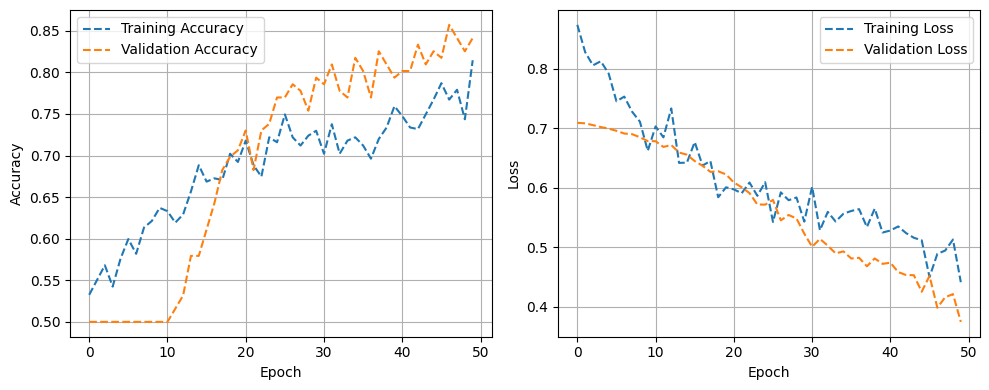

In [17]:
import matplotlib.pyplot as plt

# Merge histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_histories(history1, history2)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy subplot
ax1.plot(combined_history['accuracy'], label='Training Accuracy',linestyle='--')
ax1.plot(combined_history['val_accuracy'], label='Validation Accuracy',linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss subplot
ax2.plot(combined_history['loss'], label='Training Loss',linestyle='--')
ax2.plot(combined_history['val_loss'], label='Validation Loss',linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('loss_acc_sgd.eps',dpi=600)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.7957    0.9136    0.8506        81
           1     0.8955    0.7595    0.8219        79

    accuracy                         0.8375       160
   macro avg     0.8456    0.8365    0.8362       160
weighted avg     0.8450    0.8375    0.8364       160


Confusion Matrix (4 decimal places):
[[74.  7.]
 [19. 60.]]

Specificity: 0.9136


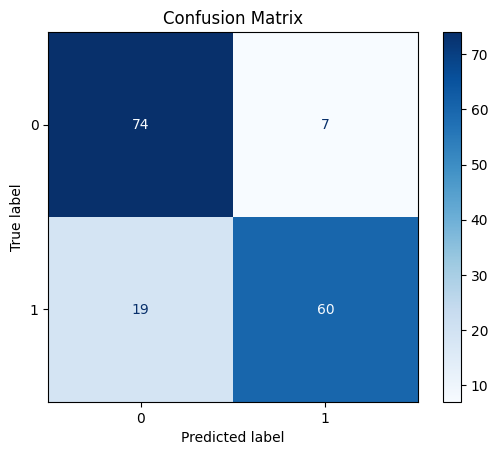

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model=load_model("SGD_Model.keras")

# True labels
y_true = test_gen.classes

# Predicted probabilities
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Classification Report with 4 decimal places
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=test_gen.class_indices.keys(),
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (4 decimal places):")
print(np.round(cm.astype(np.float64), 4))

# Calculate specificity for binary classification
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"\nSpecificity: {specificity:.4f}")

# Display Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_sgd.eps',dpi = 600)
plt.show()


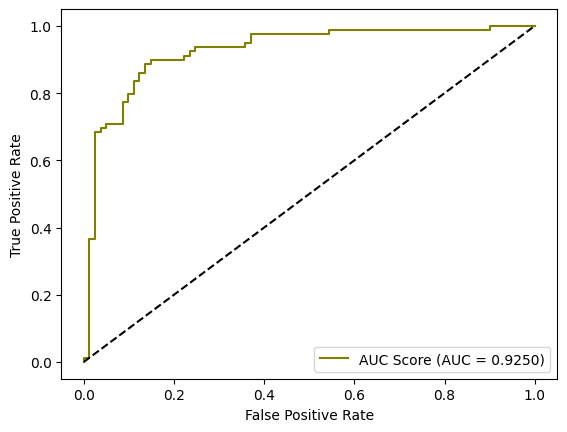

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC Score (AUC = {roc_auc:.4f})', color='olive')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('roc_sgd.eps',dpi =600)
plt.show()